In [4]:
from collections import OrderedDict

import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR10
import flwr as fl
import importlib
import os

from src.models import nets
from src.data_loader import ALLDataset
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pickle
import pydicom as dicom
import matplotlib.pyplot as plt

In [3]:

import pydicom as dicom
# specify your image path
image_path = '/home/akis-linardos/Datasets/InBreastDICOMs/53587744_5fb370d4c1c71974_MG_L_CC_ANON.dcm'
ds = dicom.dcmread(image_path)

pixel_array_numpy = ds.pixel_array

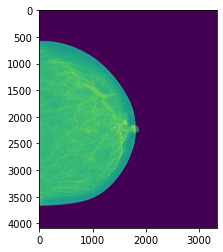

In [5]:
plt.imshow(pixel_array_numpy)

In [2]:
CSV_PATH = os.environ['csv_path']
DATASET_PATH = os.environ['dataset_path']
DATASET_PATH = "/home/lidia-garrucho/datasets/OPTIMAM/png_screening_cropped_fixed/images"
config_file = 'config.yaml'
with open(config_file) as file:
  CONFIG = yaml.safe_load(file)

In [3]:
def import_class(name):
    module_name, class_name = name.rsplit('.', 1)
    module = importlib.import_module(module_name)
    return getattr(module, class_name)
print(f'Here dataset path {DATASET_PATH}')
print(f'Here csv path {CSV_PATH}')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CRITERION = import_class(CONFIG['hyperparameters']['criterion'])

def load_data():
    """Load Breast Cancer training and validation set."""
    print('Loading data...')
    training_loader = DataLoader(ALLDataset(DATASET_PATH, CSV_PATH, 'train'), batch_size=CONFIG['hyperparameters']['batch_size'])
    validation_loader = DataLoader(ALLDataset(DATASET_PATH, CSV_PATH, 'val'), batch_size=CONFIG['hyperparameters']['batch_size'])
    test_loader = DataLoader(ALLDataset(DATASET_PATH, CSV_PATH, 'test'), batch_size=CONFIG['hyperparameters']['batch_size'])
    return training_loader, validation_loader #test_loader


Here dataset path /home/lidia-garrucho/datasets/OPTIMAM/png_screening_cropped_fixed/images
Here csv path /home/lidia-garrucho/datasets/OPTIMAM/png_screening_cropped_fixed/client_images_screening.csv


In [4]:
training_loader,_ = load_data()

Loading data...


100%|██████████| 297/297 [00:00<00:00, 84506.36it/s]


In [5]:
net = nets.SqueezeNetClassifier(in_ch=3, out_ch=1, linear_ch=512, pretrained=True)
net.to(DEVICE)
criterion=CRITERION
epochs=3
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []
cumulative_loss = 0.0
predictions = []
print('Training...')
for _ in range(epochs):
    for i, batch in enumerate(tqdm(training_loader)):
        images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        cumulative_loss += loss.item()
        loss.backward()
        optimizer.step()

        losses.append(loss)

train_results = cumulative_loss #(losses, predictions)

Using cache found in /home/akis-linardos/.cache/torch/hub/pytorch_vision_v0.6.0


Training...


  0%|          | 0/670 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/BFP/src/preprocessing/optimam_train_hologic_landmarks.pth'

In [ ]:
train_results

In [ ]:
seed = 42  # for reproducibility

# Imports
import os
import yaml
import enum
import copy
import random
import tempfile
import warnings
import multiprocessing
import pickle
import numpy as np
from collections import OrderedDict
import sys
sys.path.append('/BFP')

from math import floor, ceil
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
torch.manual_seed(seed)
from PIL import Image
from src.data_augmentation.breast_density.data.resize_image import *
from src.preprocessing.histogram_standardization import apply_hist_stand_landmarks
from src.data_handling.mmg_detection_datasets import *

from torch.utils.data import BatchSampler, RandomSampler 

    
pathologies = ['mass'] #['mass', 'calcifications', 'suspicious_calcifications', 'architectural_distortion'] # None to select all
# Resize images keeping aspect ratio
rescale_height = 224
rescale_width = 224

image_ctr = 0

def preprocess_one_image_OPTIMAM(image):
    label = np.single(0) if image.status=='Benign' else np.single(1)
    # status = image.status # ['Benign', 'Malignant', 'Interval Cancer', 'Normal']
    manufacturer = image.manufacturer # ['HOLOGIC, Inc.', 'Philips Digital Mammography Sweden AB', 'GE MEDICAL SYSTEMS', 'Philips Medical Systems', 'SIEMENS']
    # view = image.view # MLO_VIEW = ['MLO','LMLO','RMLO', 'LMO', 'ML'] CC_VIEW = ['CC','LCC','RCC', 'XCCL', 'XCCM']
    # laterality = image.laterality # L R

    img_pil = Image.open(image.path).convert('RGB')
    img_np = np.array(img_pil)
    scale_size = (rescale_height, rescale_width)
    img_np = np.uint8(img_np) if img_np.dtype != np.uint8 else img_np.copy()
    rescaled_img, scale_factor = imrescale(img_np, scale_size, return_scale=True, backend='pillow')
    image = torch.from_numpy(rescaled_img).permute(2,0,1)
    
    # Histogram Matching 
    landmarks_values = torch.load(HOME_PATH / CONFIG['paths']['landmarks'])
    apply_hist_stand_landmarks(image, landmarks_values)

    paddedimg = torch.zeros(3,224,224)
    c,h,w = image.shape
    paddedimg[:,-h:,-w:]=image
    return paddedimg, label



In [ ]:
mode='train'
load_max=1000
center=None 
subjects = OPTIMAMDataset(CSV_PATH, DATASET_PATH, detection=False, load_max=-1, 
                    cropped_to_breast=True) # we should be able to load any dataset with this

subjects_selected = {}
if center!=None:
    total_subjects = subjects.get_images_by_site(center)
else:
    # General case
    subjects_selected['benign'] = subjects.get_clients_by_status('Benign')[:load_max] #Note that clients means subjects here.
    subjects_selected['malignant'] = subjects.get_clients_by_status('Malignant')[:load_max]
    subjects_selected['normal'] = subjects.get_clients_by_status('Normal')[:load_max]
    total_subjects = subjects_selected['benign'] + subjects_selected['malignant'] + subjects_selected['normal']
random.shuffle(total_subjects) 
# Data Split
training_subjects = total_subjects[:int(len(total_subjects)*0.8)]
validation_subjects = total_subjects[int(len(total_subjects)*0.8):int(len(total_subjects)*0.9)]
test_subjects = total_subjects[int(len(total_subjects)*0.9):]

def extract_images(subjects):
    images=[]
    for subject in tqdm(subjects):
        for study in subject:
            for image in study:
                images.append(image)
    return images

# if mode == 'train':
#     self.images = extract_images(training_subjects)
# elif mode == 'val':
#     self.images = extract_images(validation_subjects) 
# elif mode == 'test':
#     self.images = extract_images(test_subjects)